### In this section, we explore the sample on which we will run the scarlet model!!

Some things I want to do with the eventual final scarlet test:

1) build scarlet models for nearby low-mass dwarf galaxies. Nearby as most likely to be shredded, and low mass so angular size is smaller and thus less expensive

2) Want to make a plot comparing the scarlet mags with aperture photo mags

3) When do we need the LSB wavelet component included or not?

4) Need to visually inspect ones to avoid repetition

3) For the most irregular ones, make a scarlet model highlighting how future directions could be useful here??

In constructing the scarlet model, need to thing about how to thing about masking other sources outside main island .. and how large to choose the cutout size 

In [2]:
import os
import sys

import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, print_radecs, sdss_rgb

In [137]:
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

from desi_lowz_funcs import get_stellar_mass_mia

def filter_close_sources(ra, dec, radius_arcsec=30):
    """
    Remove sources that lie within <radius_arcsec of another source.
    Keeps the first instance encountered.

    ra, dec : arrays in degrees
    returns : indices of the sources to keep
    """
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    keep = []
    mask = np.ones(len(coords), dtype=bool)

    for i in range(len(coords)):
        if not mask[i]:
            continue  # this one was already excluded
        keep.append(i)
        # mark all others within the radius as excluded
        sep = coords[i].separation(coords)
        mask[sep < (radius_arcsec*u.arcsec)] = False

    return np.array(keep)



def basic_filter_scarlet(data):
    data_scarlet = data[(data["Z"] < 0.01) & (data["LOG_MSTAR_M24"] < 8.5) & (data["LOG_MSTAR_M24"] > 6) 
                        & (data["MASKBITS"]==0) & (data["is_south"] == 1)  ]

    return data_scarlet
    

def do_consolidate(cat,sample):
    '''
    Here we consolidate the photo
    '''
    
    cat = consolidate_new_photo(cat,sample=sample, use_pcnn=False)

    cat = cat[cat["PHOTO_MASKBIT"] == 0]

    ra_tgt = cat["RA"].data
    dec_tgt = cat["DEC"].data
    
    cat = consolidate_positions_and_shapes(cat)

    cat["RA_TARGET"] = ra_tgt
    cat["DEC_TARGET"] = dec_tgt

    #add stellar mass
    gr_colors = cat["MAG_G_BEST"].data - cat["MAG_R_BEST"].data
    log_mstars_M24 = get_stellar_mass_mia(gr_colors, cat["MAG_G_BEST"].data , cat["Z_CMB"].data, d_in_mpc = cat["DIST_MPC_FIDU"].data, input_zred =  False)

    cat["LOG_MSTAR_M24"] = log_mstars_M24
    
    return cat
    

def get_entire_scarlet():

    data_bgsb = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
    data_bgsf = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
    data_lowz = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
    data_elg = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")


    ##consolidate photo into best and measure stellar mass
    data_bgsb = do_consolidate(data_bgsb, "BGS_BRIGHT")
    data_bgsf = do_consolidate(data_bgsf, "BGS_FAINT")
    data_lowz = do_consolidate(data_lowz, "LOWZ")
    data_elg = do_consolidate(data_elg, "ELG")

    data_bgsb = basic_filter_scarlet(data_bgsb)
    data_bgsf = basic_filter_scarlet(data_bgsf)
    data_lowz = basic_filter_scarlet(data_lowz)
    data_elg = basic_filter_scarlet(data_elg)

    print(len(data_bgsb), len(data_bgsf), len(data_lowz), len(data_elg))

    data_all = vstack([data_bgsb, data_bgsf, data_lowz, data_elg])

    print(len(data_all))
    
    # example usage:
    keep_indices = filter_close_sources( data_all["RA"].data, data_all["DEC"].data, radius_arcsec = 60 )

    data_all = data_all[keep_indices]

    print(len(data_all))

    return data_all

    


In [138]:
data_scarlet_f = get_entire_scarlet()

Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
[False False False False False]
FRACTION REVERT BACK TO TRACTOR: 0.21886002474069846
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.059806
MASKBIT=2^2, bad resid, fraction : 0.0070
MASKBIT=2^3, cog curve decrease, fraction: 0.0124
MASKBIT=2^4, aperfrac-in image, fraction: 0.001570
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047340
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000428
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.049339
MASKBIT=2^12, near sga outskirts, fraction: 0.013798
Fraction of sources where org trac is likely good = 0.5352554952897517
Updating the maskbits to reflect some obje

100%|██████████| 18243/18243 [00:00<00:00, 275992.41it/s]


[1.78110534 2.33594839 2.17207318 3.67550599 8.03611348]
Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
[False False False False False]
FRACTION REVERT BACK TO TRACTOR: 0.2929171668667467
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0096
MASKBIT=2^1, cog not converge, fraction: 0.084634
MASKBIT=2^2, bad resid, fraction : 0.0117
MASKBIT=2^3, cog curve decrease, fraction: 0.0069
MASKBIT=2^4, aperfrac-in image, fraction: 0.000600
MASKBIT=2^5, aperfrac-mask image, fraction: 0.126050
MASKBIT=2^6, image-frac mask, fraction: 0.000900
MASKBIT=2^7, bad colors, fraction: 0.000600
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.110444
MASKBIT=2^10, aper-cen masked, fraction: 0.110444
MASKBIT=2^12, near sga o

100%|██████████| 3036/3036 [00:00<00:00, 270807.43it/s]


[3.61252924 1.99606541 1.30425311 2.93792648 1.91425036]
Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
[False False False  True False]
FRACTION REVERT BACK TO TRACTOR: 0.46557759626604434
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0058
MASKBIT=2^1, cog not converge, fraction: 0.182030
MASKBIT=2^2, bad resid, fraction : 0.0058
MASKBIT=2^3, cog curve decrease, fraction: 0.0198
MASKBIT=2^4, aperfrac-in image, fraction: 0.000000
MASKBIT=2^5, aperfrac-mask image, fraction: 0.022170
MASKBIT=2^6, image-frac mask, fraction: 0.000000
MASKBIT=2^7, bad colors, fraction: 0.000000
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.099183
MASKBIT=2^10, aper-cen masked, fraction: 0.022170
MASKBIT=2^12, near sga 

100%|██████████| 766/766 [00:00<00:00, 271629.77it/s]


[4.73222102 3.80420946 2.05380845 1.96710086 4.60792253]
Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
[False False False False False]
FRACTION REVERT BACK TO TRACTOR: 0.1884869196323356
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.1758
MASKBIT=2^1, cog not converge, fraction: 0.036845
MASKBIT=2^2, bad resid, fraction : 0.0029
MASKBIT=2^3, cog curve decrease, fraction: 0.0021
MASKBIT=2^4, aperfrac-in image, fraction: 0.000412
MASKBIT=2^5, aperfrac-mask image, fraction: 0.189115
MASKBIT=2^6, image-frac mask, fraction: 0.001355
MASKBIT=2^7, bad colors, fraction: 0.001414
MASKBIT=2^8, source not on segment, fraction: 0.0041
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.045997
MASKBIT=2^10, aper-cen masked, fraction: 0.018481
MASKBIT=2^12, near sga o

100%|██████████| 47376/47376 [00:00<00:00, 277095.51it/s]


[1.41168685 1.58307479 8.587506   1.55131915 2.69199496]
Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column
253 5 0 41
299
255


## Make some basic VI plots to check robustness of Scarlet model. 

## Make plot of difference between scarlet mag and best mag

In [68]:
from matplotlib.patheffects import withStroke
import requests
import os
import sys
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.patches import Circle


session = requests.Session()

def get_tractor_model(ra,dec,size=350,path=None):
    '''
    We extract the model image from Tractor using hte url method
    '''
    if os.path.exists(path):
        pass
    else:
        url_prefix = 'https://www.legacysurvey.org/viewer/'
    
        url = url_prefix + f'cutout.fits?ra={ra}&dec={dec}&size=%s&'%size
        
        url += 'layer=ls-dr9-model&pixscale=0.262&bands=grz'
        resp = session.get(url)
        with open(path, "wb") as f:
            f.write(resp.content)
            
    return      

def get_tractor_model_resid(ra,dec,size=350,path=None):
    '''
    We extract the model image from Tractor using hte url method
    '''

    if os.path.exists(path):
        pass
    else:
        url_prefix = 'https://www.legacysurvey.org/viewer/'
    
        url = url_prefix + f'cutout.fits?ra={ra}&dec={dec}&size=%s&'%size
        
        url += 'layer=ls-dr9-resid&pixscale=0.262&bands=grz'
        resp = session.get(url)
        with open(path, "wb") as f:
            f.write(resp.content)
            
    return  


In [111]:
def plot_VI(index, data_scarlet):

    ra = data_scarlet["RA"][index]
    dec = data_scarlet["DEC"][index]
    
    file_path = data_scarlet["FILE_PATH"][index]
    img_path = data_scarlet["IMAGE_PATH"][index]
    try:
        img_data_total = fits.open(img_path)[0].data
    
        tgid = data_scarlet["TARGETID"][index]
        
        # print(file_path)
        
        scar_mags = np.load( file_path + "/scarlet_mags.npy")
    
        #get the dwarf only model with scarlet
        scarlet_total_model = np.load(file_path + "/total_model_rgb.npy")
        scarlet_model_rgb = np.load(file_path + "/dwarf_model_rgb.npy")
        scarlet_resid_rgb = np.load(file_path + "/model_residual_rgb.npy")
        bounding_box_coords = np.load(file_path + "/bounding_box_coords.npy")
        
        ##### PREPARING THE ACTUAL IMAGES!
        img_data = img_data_total[:, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
        img_rgb = sdss_rgb([img_data[0],img_data[1],img_data[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
    
        ## load the dwarf only model with tractor!!
        
        tractor_bkg_model = np.load(file_path + "/tractor_background_model.npy")
        tractor_blend_model = np.load(file_path + "/tractor_blend_remove_model.npy")
        
        tractor_dwarf_model = img_data_total - tractor_bkg_model - tractor_blend_model
        tractor_dwarf_model = tractor_dwarf_model[ :, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
        #apply the aperture mask
        aper_cog_mask = np.load(file_path + "/final_mask_cog.npy")
        aper_cog_mask = aper_cog_mask[bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
        
        tractor_dwarf_model[:, aper_cog_mask] = 0
        tractor_dwarf_model_rgb = sdss_rgb([tractor_dwarf_model[0],tractor_dwarf_model[1],tractor_dwarf_model[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
    
        desi_fiber_pos = np.load(file_path + "/fiber_pix_pos_org.npy")
        #we need to update this 
    
        desi_fiber_pos = desi_fiber_pos - np.array([bounding_box_coords[0] , bounding_box_coords[2]] )
        
        fig,ax = make_subplots(ncol = 1, nrow = 4, return_fig = True,row_spacing = 0.)
    
        ax[3].set_title(f"{index}, {tgid}",fontsize = 15)
        ax[3].imshow(img_rgb,origin="lower",zorder = 0)
    
        radius_in_pixels = (1.5/2)/0.262 #radius of DESI fiber diameter
        circle = patches.Circle( (desi_fiber_pos[1], desi_fiber_pos[0]),radius_in_pixels, color='limegreen', fill=False, linewidth=1.5,ls ="--")
        ax[3].add_patch(circle)
        
        fs = 15
        
        ax[0].set_ylabel(r"Scarlet Residuals",fontsize = fs)
        ax[1].set_ylabel(r"Scarlet Reconstruction",fontsize = fs)
        ax[2].set_ylabel(r"Original Reconstruction",fontsize = fs)
        ax[3].set_ylabel(r"$grz$ image",fontsize = fs)
            
        ax[3].text(0.5, 0.95,f"({ra:.3f}, {dec:.3f})",color = "white",fontsize = 15,
                     transform=ax[3].transAxes, ha = "center", verticalalignment='top')
        
    
        fst = 15
        ax[2].text(
        0.5, 0.925,
        rf"$\mathrm{{mag_{{aper}}}}$: ({data_scarlet['MAG_G_BEST'][index]:.1f}, "
        rf"{data_scarlet['MAG_R_BEST'][index]:.1f}, "
        rf"{data_scarlet['MAG_Z_BEST'][index]:.1f})",
        ha="center", va="center",
        fontsize=fst, color="white",
        transform=ax[2].transAxes)
    
        ax[1].text(
        0.5, 0.925,
        rf"$\mathrm{{mag_{{scarlet}}}}$: ({scar_mags[0]:.1f}, "
        rf"{scar_mags[1]:.1f}, "
        rf"{scar_mags[2]:.1f})",
        ha="center", va="center",
        fontsize=fst, color="white",
        transform=ax[1].transAxes
    )
    
        ax[2].imshow(tractor_dwarf_model_rgb,origin="lower")    
        ax[1].imshow(scarlet_model_rgb,origin="lower")
        ax[0].imshow(scarlet_resid_rgb,origin="lower")
    
    
        org_size = np.shape(img_data)[1]
    
        for axi in ax:
            axi.set_xticks([])
            axi.set_yticks([])
    
    
            bar_frac = 15/(org_size * 0.262)
    
            x_start_frac = 0.07  # 7% from left
            y_start_frac = 0.07  # 7% from bottom
            
            # Draw the scale bar in axes coordinates
            axi.plot([x_start_frac, x_start_frac + bar_frac],
                    [y_start_frac, y_start_frac],
                    color='white', lw=1, transform=axi.transAxes)    
        

        save_path = f"/pscratch/sd/v/virajvm/trash/scarlet_comp_plots/scarlet_tractor_compare_{index}.png"
        plt.savefig(save_path,bbox_inches="tight",dpi=150)
        plt.close()

        return save_path

    except:
        plt.close()
        print(f"Error in {index}: {file_path}")

        return None


In [112]:
np.where(data_scarlet_f["TARGETID"]==39627409678405366)

(array([1]),)

In [116]:
all_scar_imgs = []
for index in range(len(data_scarlet_f)):
    path_i = plot_VI(index, data_scarlet_f)
    if path_i is not None:
        all_scar_imgs.append(path_i)

Error in 0: /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-050m020-060m015/0552m187/BGS_BRIGHT_tgid_39627340371723696
Error in 3: /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-310m010-320m005/3193m100/BGS_BRIGHT_tgid_39627549499723844
Error in 8: /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-210m010-220m005/2151m077/BGS_BRIGHT_tgid_39627601534256349
Error in 10: /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150m010-160m005/1552m070/BGS_BRIGHT_tgid_39627618525385721
Error in 12: /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-170m010-180m005/1753m065/BGS_BRIGHT_tgid_39627630869219269
Error in 19: /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-200m010-210m005/2092m055/BGS_BRIGHT_tgid_39627655481396172
Error in 20: /pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-210m010-220m005/2122m052/BGS_BRIGHT_tgid_39627661550556653
Error in 

In [128]:
data_scarlet_f[data_scarlet_f["TARGETID"]==39627860310231813]["FILE_PATH","PCNN_FRAGMENT"]

FILE_PATH,PCNN_FRAGMENT
bytes128,float32
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-180p000-190p005/1851p030/ELG_tgid_39627860310231813,0.99991024


In [117]:
##given all these pdfs, make a scroolabe one

from desi_lowz_funcs import get_scrollable_pdfs
import glob

In [118]:
get_scrollable_pdfs(all_scar_imgs, "/pscratch/sd/v/virajvm/trash/scarlet_all_comp.pdf")

Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/scarlet_all_comp.pdf


## Scarlet photometry vs. our photometry comparison

We remove the scarlet models that do not look correct after VI'ing

In [139]:
##loop through the files

all_best_mags = []
all_scar_mags = []
all_scar_R4_mags = []

bad_models = [39627673282024515, 39627678508126278, 39627697344746107, 39627703434871529, 39627708442870674,
39627737085772411, 39627764231307714,  39627764231307714, 39627775753060564, 39627776650644919, 
39627777950881432, 39627817771599530, 39627835534480059, 39627848771699217, 39627857147727552, 
39627872935084634, 39627890874123509, 39627923212209600, 39627932791999997, 39627981563363983, 
39627981768885600, 39628033274939609, 39628124182286640, 39628131211939268, 39628180209797010, 
39628197762959956, 39628249424200280, 39628322673530195, 39628352629245052, 39628459705635056,
39628414809801156, 39627329424596254, 39627335137233103] 


print(len(data_scarlet_f))

for i in range(len(data_scarlet_f)):

    tgidi = data_scarlet_f["TARGETID"].data[i]
    if i in bad_models:
        pass
    else:        
        try:
            file_path = data_scarlet_f["FILE_PATH"][i]
    
            scar_R4_mags = np.load(file_path + "/scarlet_mags_R4.npy")
        
            all_scar_R4_mags.append(scar_R4_mags[0])
            all_scar_R4_mags.append(scar_R4_mags[1])
            all_scar_R4_mags.append(scar_R4_mags[2])
    
            #get the scarlet mags
            scar_mags = np.load(file_path + "/scarlet_mags.npy")
        
            all_scar_mags.append(scar_mags[0])
            all_scar_mags.append(scar_mags[1])
            all_scar_mags.append(scar_mags[2])
    
            
            #load in the aperture cog mags
            gmag_best = data_scarlet_f["MAG_G_BEST"][i]
            rmag_best = data_scarlet_f["MAG_R_BEST"][i]
            zmag_best = data_scarlet_f["MAG_Z_BEST"][i]
        
            all_best_mags.append(gmag_best)
            all_best_mags.append(rmag_best)
            all_best_mags.append(zmag_best)
              
        except:
            print(f"{i} index did not work")

all_best_mags = np.array(all_best_mags)
all_scar_mags = np.array(all_scar_mags)
all_scar_R4_mags = np.array(all_scar_R4_mags)

mag_diffs = all_best_mags - all_scar_mags
mag_diffs_r4 = all_best_mags - all_scar_R4_mags


255
0 index did not work
3 index did not work
8 index did not work
10 index did not work
12 index did not work
19 index did not work
20 index did not work
22 index did not work
28 index did not work
33 index did not work
35 index did not work
36 index did not work
37 index did not work
39 index did not work
43 index did not work
44 index did not work
48 index did not work
50 index did not work
51 index did not work
52 index did not work
54 index did not work
58 index did not work
60 index did not work
62 index did not work
67 index did not work
69 index did not work
70 index did not work
71 index did not work
73 index did not work
76 index did not work
77 index did not work
79 index did not work
82 index did not work
83 index did not work
86 index did not work
87 index did not work
94 index did not work
99 index did not work
106 index did not work
107 index did not work
108 index did not work
116 index did not work
117 index did not work
123 index did not work
133 index did not work
13

In [140]:
from scipy import stats

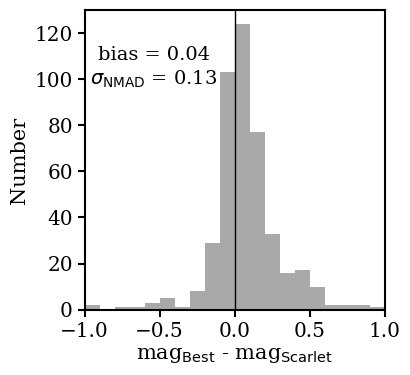

In [145]:
ax = make_subplots(ncol = 1, nrow = 1)

ax[0].hist(mag_diffs_r4,range=(-1,1),bins=20,color = "darkgrey")
# ax[0].hist(mag_diffs,range=(-1,1),bins=15,color = "k",histtype = "step",ls = "-.",lw = 1,alpha=0.75)

ax[0].set_xlim([-1,1])

fs=14
ax[0].text(0.23,0.85,rf"bias = {np.median(mag_diffs_r4):.2f}",fontsize = fs,ha="center",va="center",
          transform=ax[0].transAxes )

ax[0].text(0.23,0.77,rf"$\sigma_{{\rm NMAD}}$ = {stats.median_abs_deviation(mag_diffs_r4, scale = 'normal'):.2f}",fontsize = fs,ha="center",va="center",
          transform=ax[0].transAxes )

ax[0].axvline(x = 0,color = "k",lw = 1)
ax[0].set_xlabel(r"mag$_{\rm Best}$ - mag$_{\rm Scarlet}$",fontsize = 15)
ax[0].set_ylabel(r"Number",fontsize = 15)

plt.savefig("/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/scarlet_aper_compare.pdf",bbox_inches="tight")
plt.show()

In [72]:
targetids_to_plot = [
    39627696736569216,
    39627902668510595,
    39627950118668787,
    39627893835307165,
    39627957563555904,
    39627744694244896,
    39627872356275243,
    39627740013401179,
    39627951129493854,
    39627757478481897,
    39627829515651318,
    39627777950881432,
    39627755704288400,
    39627752084603161,
    39627666902485913,
    39628504479829681,
    39627667204478543,
    39628527288452786,
    39627971878718838,
    39627854903771809,
    39627835962296788,
    39627896603545910,
    39627691422387329,
    39627643653460508,
    39627866891094974,
    39627790391187481,
    39627600171107076,
    39628147238374191,
    39627685319676194,
    39627703506176030,
    39628470438857978,
    39628481516012917,
    39627751577095177,
    39627973615161184,
    39627722128887172,
    39627669465203619,
    39627906002981591,
    39627847312083386,
]


In [146]:
final_tgids_to_plot= [39627950118668787, 39627906002981591, 39627685319676194, 39627691422387329, 39628527288452786, 39628504479829681, 39627740013401179]



In [172]:

def plot_f(tgid, data_scarlet, plot_label = False):
    '''
    Input is the TARGETID we want to plot, and data_scarlet is the entire catalog
    '''

    index = np.where(data_scarlet["TARGETID"] == tgid)[0][0]
    
    ra = data_scarlet["RA"][index]
    dec = data_scarlet["DEC"][index]
    zred = data_scarlet["Z"][index]
    
    file_path = data_scarlet["FILE_PATH"][index]
    img_path = data_scarlet["IMAGE_PATH"][index]


    img_data_total = fits.open(img_path)[0].data

    wcs = WCS(fits.getheader(img_path))
    
    print(file_path)
    
    scar_mags = np.load( file_path + "/scarlet_mags_R4.npy")

    #get the dwarf only model with scarlet
    scarlet_total_model = np.load(file_path + "/total_model_rgb.npy")
    scarlet_model_rgb = np.load(file_path + "/dwarf_model_rgb.npy")
    scarlet_resid_rgb = np.load(file_path + "/model_residual_rgb.npy")
    bounding_box_coords = np.load(file_path + "/bounding_box_coords.npy")

    shift_y, _, shift_x, _ = bounding_box_coords
    
    ##### PREPARING THE ACTUAL IMAGES!
    img_data = img_data_total[:, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    img_rgb = sdss_rgb([img_data[0],img_data[1],img_data[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

    ## load the dwarf only model with tractor!!
    
    tractor_bkg_model = np.load(file_path + "/tractor_background_model.npy")
    
    tractor_source_model = np.load(file_path + "/tractor_source_model.npy")
    tractor_source_model = tractor_source_model[ :, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    
    tractor_blend_model = np.load(file_path + "/tractor_blend_remove_model.npy")
    
    tractor_dwarf_model = img_data_total - tractor_bkg_model - tractor_blend_model
    tractor_dwarf_model = tractor_dwarf_model[ :, bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    #apply the aperture mask
    aper_cog_mask = np.load(file_path + "/final_mask_cog.npy")
    aper_cog_mask = aper_cog_mask[bounding_box_coords[0] : bounding_box_coords[1], bounding_box_coords[2] : bounding_box_coords[3] ]
    
    tractor_dwarf_model[:, aper_cog_mask] = 0
    tractor_dwarf_model_rgb = sdss_rgb([tractor_dwarf_model[0],tractor_dwarf_model[1],tractor_dwarf_model[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

    desi_fiber_pos = np.load(file_path + "/fiber_pix_pos_org.npy")
    #we need to update this 

    desi_fiber_pos = desi_fiber_pos - np.array([bounding_box_coords[0] , bounding_box_coords[2]] )
    
    fig,ax = make_subplots(ncol = 1, nrow = 4, return_fig = True,row_spacing = 0.)

    ax[3].imshow(img_rgb,origin="lower",zorder = 0)

    circle = patches.Circle( (desi_fiber_pos[1], desi_fiber_pos[0]),3, color='r', fill=False, linewidth=1.5,ls ="-")
    ax[3].add_patch(circle)
    
    fs = 14
    if plot_label:
        # ax[0].set_ylabel(r"Scarlet Residuals",fontsize = fs)
        ax[0].set_ylabel(r"Scarlet Model",fontsize = fs)
        ax[1].set_ylabel(r"Our Reconstruction",fontsize = fs)
        ax[2].set_ylabel(r"DESI Source Tractor Model",fontsize = fs)
        ax[3].set_ylabel(r"$grz$ image",fontsize = fs)
            
    ax[3].text(0.5, 0.95,f"({ra:.3f}, {dec:.3f}), z = {zred:.3f}",color = "white",fontsize = 12,
                 transform=ax[3].transAxes, ha = "center", verticalalignment='top')
    
    fst = 13

    ax[2].text(
    0.5, 0.925,
    rf"$\mathrm{{mag_{{DR9}}}}$: ({data_scarlet['MAG_G'][index]:.1f}, "
    rf"{data_scarlet['MAG_R'][index]:.1f}, "
    rf"{data_scarlet['MAG_Z'][index]:.1f})",
    ha="center", va="center",
    fontsize=fst, color="white",
    transform=ax[2].transAxes)

    
    ax[1].text(
    0.5, 0.925,
    rf"$\mathrm{{mag_{{Best}}}}$: ({data_scarlet['MAG_G_BEST'][index]:.1f}, "
    rf"{data_scarlet['MAG_R_BEST'][index]:.1f}, "
    rf"{data_scarlet['MAG_Z_BEST'][index]:.1f})",
    ha="center", va="center",
    fontsize=fst, color="white",
    transform=ax[1].transAxes)

    ax[0].text(
    0.5, 0.925,
    rf"$\mathrm{{mag_{{Scarlet}}}}$: ({scar_mags[0]:.1f}, "
    rf"{scar_mags[1]:.1f}, "
    rf"{scar_mags[2]:.1f})",
    ha="center", va="center",
    fontsize=fst, color="white",
    transform=ax[0].transAxes
)

    tractor_source_rgb = sdss_rgb(tractor_source_model)
    ax[2].imshow(tractor_source_rgb, origin="lower")
    ax[1].imshow(tractor_dwarf_model_rgb,origin="lower")    
    ax[0].imshow(scarlet_model_rgb,origin="lower")
    # ax[0].imshow(scarlet_resid_rgb,origin="lower")

    ## show the ellipse !!
    ra_cen, dec_cen = data_scarlet["RA"][index], data_scarlet["DEC"][index]
    r50_pix = data_scarlet["R50_R"][index]/0.262
    shape_params = data_scarlet["SHAPE_PARAMS"][index]
    aper_xcen, aper_ycen,_ = wcs.all_world2pix(ra_cen,dec_cen,0,1)

    aper_xcen -= shift_x
    aper_ycen -= shift_y

    #we need to shift the center!!

    ell = Ellipse((aper_xcen, aper_ycen), 2 * scale_f * r50_pix, 2 * scale_f * r50_pix * shape_params[0], angle = shape_params[1] - 90,
                  facecolor='none', edgecolor="white", lw=1, ls="-", alpha=0.75)
    ax[1].add_patch(ell)


    org_size = np.shape(img_data)[1]

    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

        bar_frac = 15/(org_size * 0.262)

        x_start_frac = 0.07  # 7% from left
        y_start_frac = 0.07  # 7% from bottom
        
        # Draw the scale bar in axes coordinates
        axi.plot([x_start_frac, x_start_frac + bar_frac],
                [y_start_frac, y_start_frac],
                color='white', lw=1, transform=axi.transAxes)    
    

    plt.savefig(f"/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/scarlet_model_{index}.png",bbox_inches="tight")
    plt.close()


In [173]:
for tgidi in final_tgids_to_plot:
    try:
        plot_f(tgidi, data_scarlet_f,plot_label=True)
    except:
        pass


/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-150p005-160p010/1539p067/BGS_BRIGHT_tgid_39627950118668787
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-030p005-040p010/0332p050/BGS_BRIGHT_tgid_39627906002981591
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190m005-200p000/1926m042/BGS_BRIGHT_tgid_39627685319676194
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-170p030-180p035/1754p322/BGS_BRIGHT_tgid_39628527288452786
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-020p030-030p035/0211p312/BGS_BRIGHT_tgid_39628504479829681
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-210m005-220p000/2148m020/BGS_BRIGHT_tgid_39627740013401179


## VERY DIFFUSE OBJECT EXAMPLE PLOT

In [4]:
data_bgsb = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")


In [15]:
# let us consolidate this 
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes


data_bgsb = consolidate_new_photo(data_bgsb,sample="BGS_BRIGHT")

data_bgsb = consolidate_positions_and_shapes(data_bgsb)



Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
[ True False  True False False]
FRACTION REVERT BACK TO TRACTOR: 0.5352554952897517
Need to include the VI column that only does the aperture no subtract photo
Adding the photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.059806
MASKBIT=2^2, bad resid, fraction : 0.0070
MASKBIT=2^3, cog curve decrease, fraction: 0.0124
MASKBIT=2^4, aperfrac-in image, fraction: 0.001570
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047340
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.000048
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.049339
MASKBIT=2^12, near sga outskirts, fraction: 0.013798
Fraction of sources where org trac is likely good = 0.5352554952897517
Updating the maskbits to reflect some objec

100%|██████████| 21018/21018 [00:00<00:00, 210828.12it/s]

[1.41482043 2.33594839 2.25301623 3.67550599 8.03611348]
Consolidated RA, DEC, and SHAPE_PARAMS columns added. Added PHOTOMETRY_UPDATED column


In [5]:
nsa_cat = Table.read("/pscratch/sd/v/virajvm/catalog/nsa_v1_0_1.fits")
# 39627824100806546

In [19]:
data_egs = data_bgsb[data_bgsb["TARGETID"] == 39627824100806546]

In [29]:
data_egs["FILE_PATH"]

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-180p000-190p005/1868p015/BGS_BRIGHT_tgid_39627824100806546


In [7]:
from desi_lowz_funcs import find_objects_nearby

nsa_egs = find_objects_nearby(nsa_cat, find_ra = 186.94195083006372, find_dec = 1.6002666871011568, ra="RA",dec="DEC")


# nsa_cat

In [40]:
nsa_egs["ELPETRO_BA","ELPETRO_PHI","ELPETRO_TH50_R","RA","DEC"]

ELPETRO_BA,ELPETRO_PHI,ELPETRO_TH50_R,RA,DEC
float32,float32,float32,float64,float64
0.87256676,145.20984,29.847254,186.94176121638188,1.6002227774547761


In [9]:
#obtaining the NSA magnitudes to compare with
nsa_petro_gflux = nsa_egs["ELPETRO_FLUX"][:,3].data
nsa_petro_rflux = nsa_egs["ELPETRO_FLUX"][:,4].data
nsa_petro_zflux = nsa_egs["ELPETRO_FLUX"][:,6].data

nsa_petro_gmag = 22.5 - 2.5*np.log10(nsa_petro_gflux.data)[0]
nsa_petro_rmag = 22.5 - 2.5*np.log10(nsa_petro_rflux.data)[0]
nsa_petro_zmag = 22.5 - 2.5*np.log10(nsa_petro_zflux.data)[0]

In [10]:
nsa_petro_gmag,nsa_petro_rmag,nsa_petro_zmag

(15.850157141685486, 15.68455457687378, 14.852027893066406)

In [36]:
from desi_lowz_funcs import process_img
from astropy.wcs import WCS
from matplotlib.patches import Ellipse, Circle



(3, 1316, 1316)


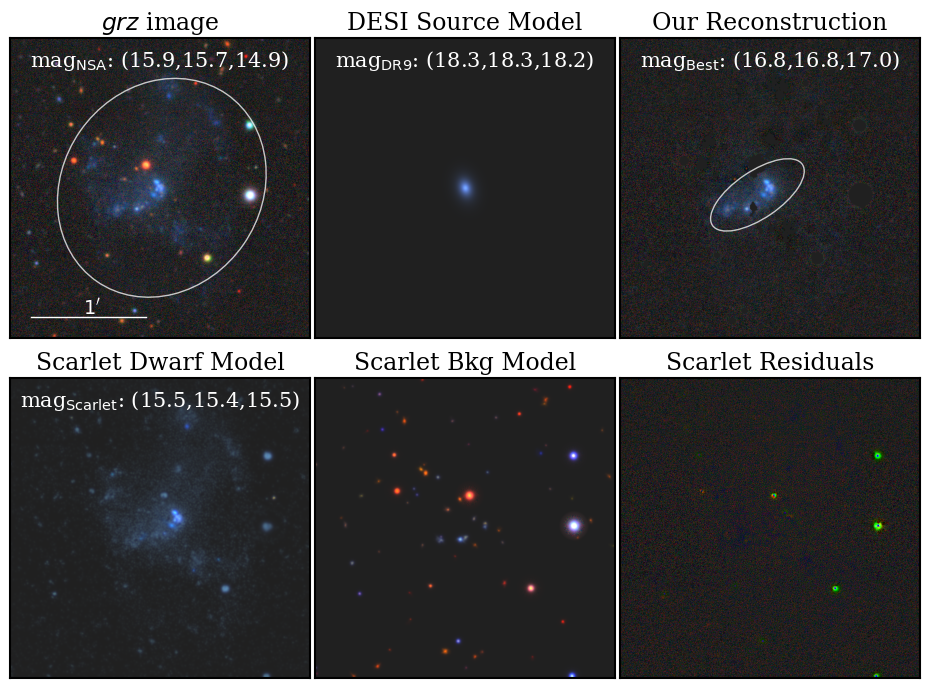

In [43]:
def cut_array(org_data, new_cutout_size = 300,invert=False):

    aper_xcen = np.shape(org_data)[1]/2
    aper_ycen = np.shape(org_data)[1]/2
    
    x_min_new = int(aper_xcen - int(new_cutout_size))
    x_max_new = int(aper_xcen + int(new_cutout_size))
    y_min_new = int(aper_ycen - int(new_cutout_size))
    y_max_new = int(aper_ycen + int(new_cutout_size))

    if invert:
        return org_data[y_min_new : y_max_new, x_min_new : x_max_new, : ]

    else:
        return org_data[:, y_min_new : y_max_new, x_min_new : x_max_new ]
    

## make a multi-panel plot of how the org grz image, include NSA photometr there, include DESI source model, 
## include our original aperture reconstruction, and then the full scarlet model of, scarlet bkg and then residuals 

file_path = data_egs["FILE_PATH"][0]

data_arr = fits.open(data_egs["IMAGE_PATH"][0])[0].data

print(data_arr.shape)

wcs = WCS(fits.getheader(data_egs["IMAGE_PATH"][0]))

new_cutout_size = 600
img_rgb, shift = process_img(data_arr, cutout_size=new_cutout_size, org_size = data_arr.shape[1], return_shift=True)

#get the desi source model
desi_source = np.load(file_path + "/tractor_source_model.npy")
desi_source_rgb = process_img(desi_source,cutout_size=new_cutout_size, org_size = desi_source.shape[1])
# desi_source_cut = cut_array(desi_source, new_cutout_size)
# desi_source_rgb = sdss_rgb(desi_source_cut)

##get our original reconstruction of the dwarf!!
org_recon = np.load(file_path + "/final_reconstruct_galaxy.npy")
org_recon_rgb = process_img(org_recon,cutout_size=new_cutout_size, org_size = org_recon.shape[1])
# org_recon_cut = cut_array(org_recon, new_cutout_size)
# org_recon_rgb = sdss_rgb(org_recon_cut)

##get our original reconstruction of the dwarf!!
scar_dwarf_rgb = np.load(file_path + "/dwarf_model_rgb.npy")
# scar_dwarf_rgb = process_img( scar_dwarf,cutout_size=new_cutout_size,org_size=scar_dwarf.shape[1] )
# print(scar_dwarf.shape, scar_dwarf_rgb.shape)
# scar_dwarf_rgb = cut_array(scar_dwarf, new_cutout_size,invert=True)

scar_bkg_rgb = np.load(file_path + "/nondwarf_model_rgb.npy")
# scar_bkg_rgb = cut_array(scar_bkg, new_cutout_size,invert=True)

scar_resid_rgb = np.load(file_path + "/model_residual_rgb.npy")
# scar_resid_rgb = cut_array(scar_resid, new_cutout_size,invert=True)

ax = make_subplots(ncol = 3, nrow = 2,col_spacing = 0.05, row_spacing = 0.4)

for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

##plot the twice the half light aperture of this object
## show the ellipse !!
ra_cen, dec_cen = data_egs["RA"][0], data_egs["DEC"][0]
r50_pix = data_egs["R50_R"][0]/0.262
shape_params = data_egs["SHAPE_PARAMS"][0]
aper_xcen, aper_ycen,_ = wcs.all_world2pix(ra_cen,dec_cen,0,1)

aper_xcen -= shift
aper_ycen -= shift

#we need to shift the center!!
scale_f = 2
ell = Ellipse((aper_xcen, aper_ycen), 2 * scale_f * r50_pix, 2 * scale_f * r50_pix * shape_params[0], angle = shape_params[1] - 90,
              facecolor='none', edgecolor="white", lw=1, ls="-", alpha=0.75)
ax[5].add_patch(ell)


##adding the NSA aperture here!!
# https://data.sdss.org/datamodel/files/ATLAS_DATA/ATLAS_MAJOR_VERSION/nsa.html -> datamodel for NSA!
ra_nsa, dec_nsa = nsa_egs["RA"][0], nsa_egs["DEC"][0]
r50_nsa_pix =  nsa_egs["ELPETRO_TH50_R"][0]/0.262
ba_nsa = nsa_egs["ELPETRO_BA"][0]
phi_nsa = nsa_egs["ELPETRO_PHI"][0] #in degrees

aper_x_nsa, aper_y_nsa,_ = wcs.all_world2pix(ra_nsa,dec_nsa,0,1)

aper_x_nsa -= shift
aper_y_nsa -= shift

scale_f = 2
ell = Ellipse((aper_x_nsa, aper_y_nsa), 2 * scale_f * r50_nsa_pix, 2 * scale_f * r50_nsa_pix * ba_nsa, angle = phi_nsa - 90,
              facecolor='none', edgecolor="white", lw=1, ls="-", alpha=0.75)
ax[3].add_patch(ell)

##


ax[3].imshow(img_rgb,origin="lower",rasterized=True)
ax[4].imshow(desi_source_rgb, origin="lower",rasterized=True)
ax[5].imshow(org_recon_rgb,origin="lower",rasterized=True)
ax[0].imshow(scar_dwarf_rgb,origin="lower",rasterized=True)
ax[1].imshow(scar_bkg_rgb,origin="lower",rasterized=True)
ax[2].imshow(scar_resid_rgb,origin="lower",rasterized=True)

fs = 17
ax[3].set_title("$grz$ image",fontsize = fs)
ax[4].set_title("DESI Source Model",fontsize = fs)
ax[5].set_title("Our Reconstruction",fontsize = fs)
ax[0].set_title("Scarlet Dwarf Model",fontsize = fs)
ax[1].set_title("Scarlet Bkg Model",fontsize = fs)
ax[2].set_title("Scarlet Residuals",fontsize = fs)

##include the photometry in relevant panels now 

fs= 15
ax[3].text(0.5,0.925, rf"mag$_{{\rm NSA}}$: ({nsa_petro_gmag:.1f},{nsa_petro_rmag:.1f},{nsa_petro_zmag:.1f})",
          ha="center",va="center", transform=ax[3].transAxes,color = "white",fontsize = fs)

ax[4].text(0.5,0.925, rf"mag$_{{\rm DR9}}$: ({data_egs['MAG_G'][0]:.1f},{data_egs['MAG_R'][0]:.1f},{data_egs['MAG_Z'][0]:.1f})",
          ha="center",va="center", transform=ax[4].transAxes,color = "white",fontsize = fs)


cog_mags = np.load(file_path + "/new_cog_mags.npy")
aper_gmag, aper_rmag, aper_zmag = cog_mags[0], cog_mags[1], cog_mags[2]

ax[5].text(0.5,0.925, rf"mag$_{{\rm Best}}$: ({aper_gmag:.1f},{aper_rmag:.1f},{aper_zmag:.1f})",
          ha="center",va="center", transform=ax[5].transAxes,color = "white",fontsize = fs)

scar_mags = np.load(file_path + "/scarlet_mags.npy")
scar_gmag, scar_rmag, scar_zmag = scar_mags[0], scar_mags[1], scar_mags[2]


ax[0].text(0.5,0.925, rf"mag$_{{\rm Scarlet}}$: ({scar_gmag:.1f},{scar_rmag:.1f},{scar_zmag:.1f})",
          ha="center",va="center", transform=ax[0].transAxes,color = "white",fontsize = fs)

##include a bar indicating 60''
bar_frac = 60/(600 * 0.262)

x_start_frac = 0.07  # 7% from left
y_start_frac = 0.07  # 7% from bottom

ax[3].plot([x_start_frac, x_start_frac + bar_frac],
            [y_start_frac, y_start_frac],color='white', lw=1, transform=ax[3].transAxes)    
fs=14
ax[3].text( x_start_frac + 0.45*bar_frac, y_start_frac*1.1, r"$1'$",fontsize = fs,color = "white", transform=ax[3].transAxes )
    
plt.savefig("/global/homes/v/virajvm/galaxy_image_prior/paper_1/plots/very_diffuse_example.pdf",bbox_inches="tight")

plt.show()

